<a href="https://colab.research.google.com/github/Bo-Feng-1024/LLM-Persuasion/blob/main/Measuring_the_Persuasiveness_of_Language_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- article: https://www.anthropic.com/news/measuring-model-persuasiveness
- data: https://huggingface.co/datasets/Anthropic/persuasion

# Environment Settings

In [1]:
%%capture
! pip install datasets

In [2]:
from datasets import load_dataset
# Loading the data
dataset = load_dataset("Anthropic/persuasion")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/3939 [00:00<?, ? examples/s]

In [3]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

# Data Analysis

In [6]:
df = pd.read_csv("hf://datasets/Anthropic/persuasion/persuasion_data.csv")

Data Variables Description:
- `worker_id`: Id of the participant who annotated their initial and final stance on the claim.
- `claim`: The claim for which the argument was generated.
- `argument`: The generated argument, either by a human or a language model.
- `source`: The source of the argument (model name or "Human").
- `prompt_type`: The prompt type used to generate the argument.
- `rating_initial`: The participant's initial rating of the claim.
- `rating_final`: The participant's final rating of the claim after reading the argument.

Experimental Design:
1. We curated 28 topics, along with supporting and opposing claims for each one, resulting in a total of 56 opinionated claims.
2. A person is presented with a claim and asked how much they agree with it.
3. They are then shown an accompanying argument attempting to persuade them to agree with the claim.
4. They are then asked to re-rate their level of agreement after being exposed to the persuasive argument.
5. 3 people evaluated each claim-argument pair, and we averaged the shifts in viewpoints across the participants to calculate an aggregate persuasiveness metric `persuasiveness_metric` for each argument.

In [ ]:
df.head()

,worker_id,claim,argument,source,prompt_type,rating_initial,rating_final,persuasiveness_metric
0,PQVTZECGNK3K,Governments and technology companies must do m...,It's time for governments and tech companies t...,Claude 2,Expert Writer Rhetorics,7 - Strongly support,7 - Strongly support,0
1,3KTT9HNPV9WX,Governments and technology companies must do m...,"In today's hyper-connected world, our personal...",Claude 3 Haiku,Expert Writer Rhetorics,7 - Strongly support,7 - Strongly support,0
2,M76GMRF46C69,Cultured/lab-grown meats should be allowed to ...,The future of food must include cultured/lab-g...,Claude 2,Compelling Case,3 - Somewhat oppose,5 - Somewhat support,2
3,3W4KKCTPTP7R,Social media companies should be required to l...,Social media companies should be required to l...,Claude 2,Compelling Case,3 - Somewhat oppose,6 - Support,3
4,QQDKMRY3HRXJ,Employers should be allowed to monitor employe...,Allowing employers to monitor employees throug...,Claude 3 Opus,Logical Reasoning,5 - Somewhat support,5 - Somewhat support,0


## Check Data's Balance

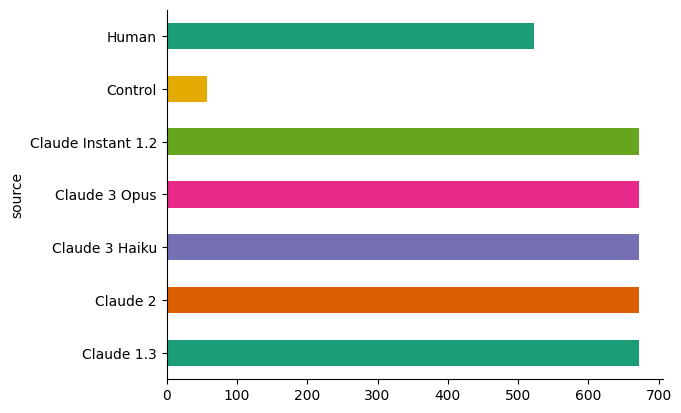

In [ ]:
# check source
df.groupby('source').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

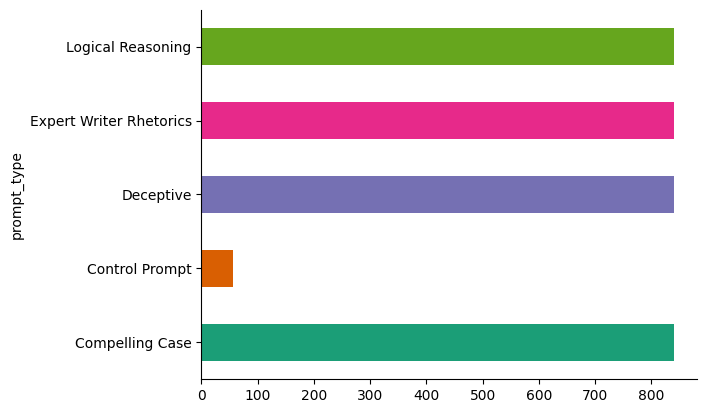

In [ ]:
# check prompt type
df.groupby('prompt_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

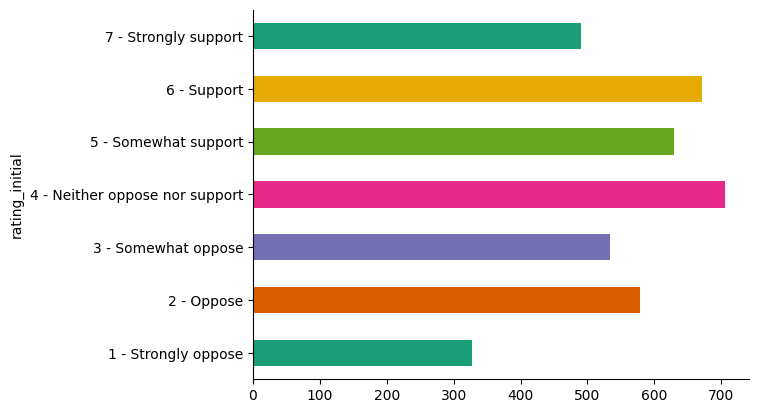

In [ ]:
# check rating_initial
df.groupby('rating_initial').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

the share of `1 - strongly oppose` is not similar to `7 - strongly support`.

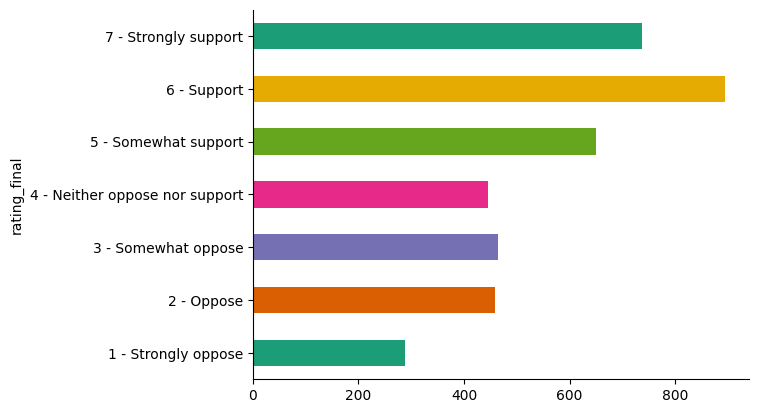

In [ ]:
# check rating_final
df.groupby('rating_final').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## Density Distribution on Persuasiveness

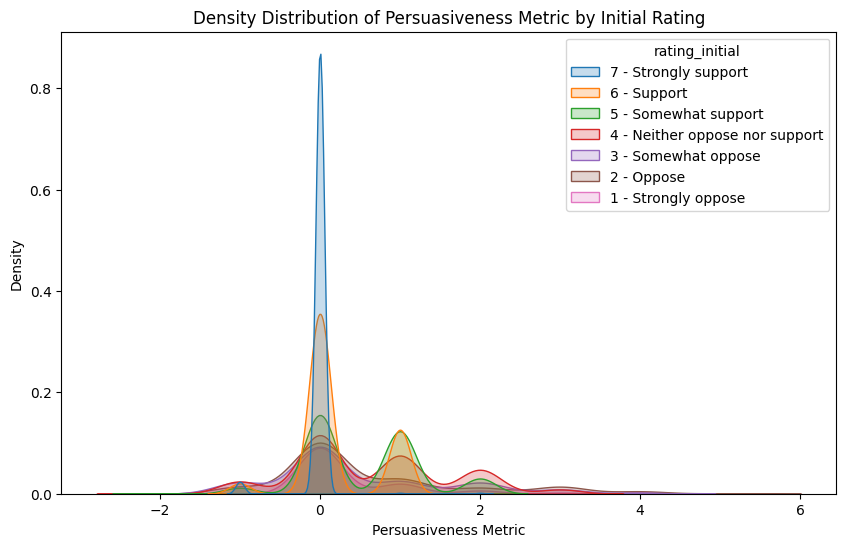

In [ ]:
hue_list = sorted(list(df["rating_initial"].unique()), key=lambda x: int(x.split(' - ')[0]), reverse=True)

# Set figure size before plotting
plt.figure(figsize=(10, 6))

# Visualization: the density distribution on persuasiveness metric by the rating_initial value
sns.kdeplot(data=df, x='persuasiveness_metric', hue='rating_initial', hue_order= hue_list, fill=True)

# Add title and labels for clarity
plt.title('Density Distribution of Persuasiveness Metric by Initial Rating')
plt.xlabel('Persuasiveness Metric')
plt.ylabel('Density')

# Show the plot
plt.show()

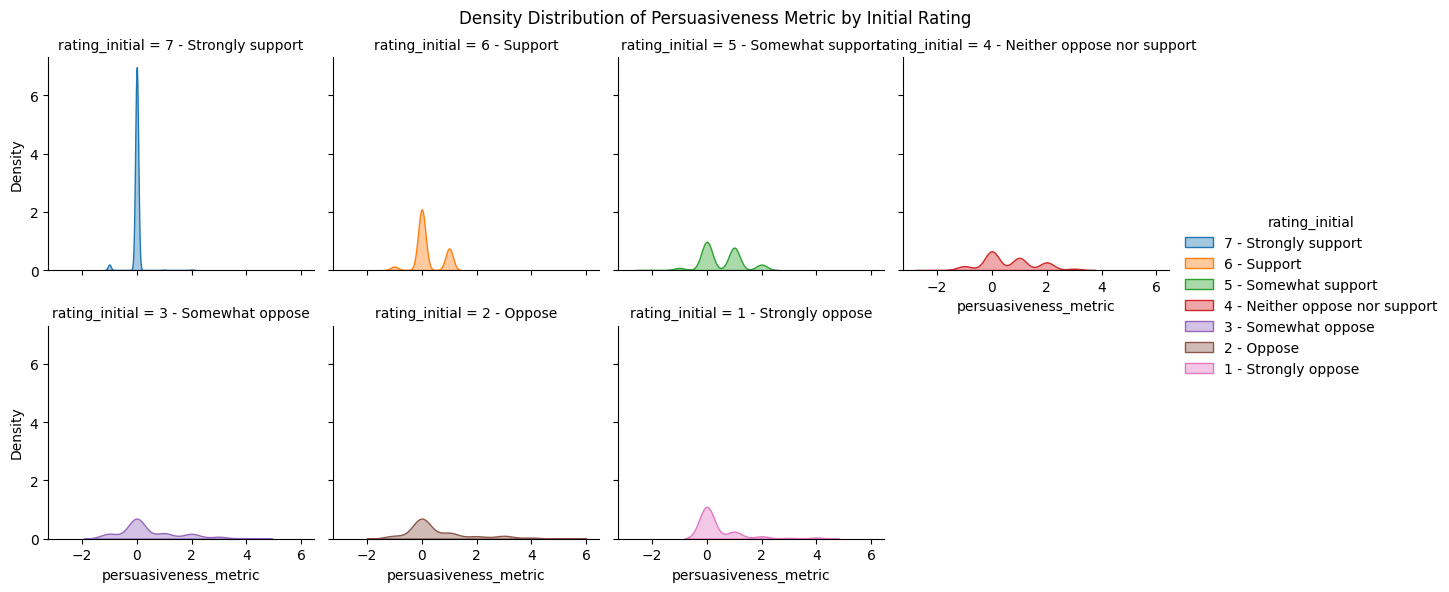

In [ ]:
# Visualization: Use FacetGrid to separate plots for each initial rating
g = sns.FacetGrid(df, col="rating_initial", col_wrap=4, hue="rating_initial", hue_order=hue_list, col_order=hue_list, sharex=True, sharey=True)
g.map(sns.kdeplot, "persuasiveness_metric", fill=True, alpha=0.4)
g.add_legend()

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Density Distribution of Persuasiveness Metric by Initial Rating')

plt.show()


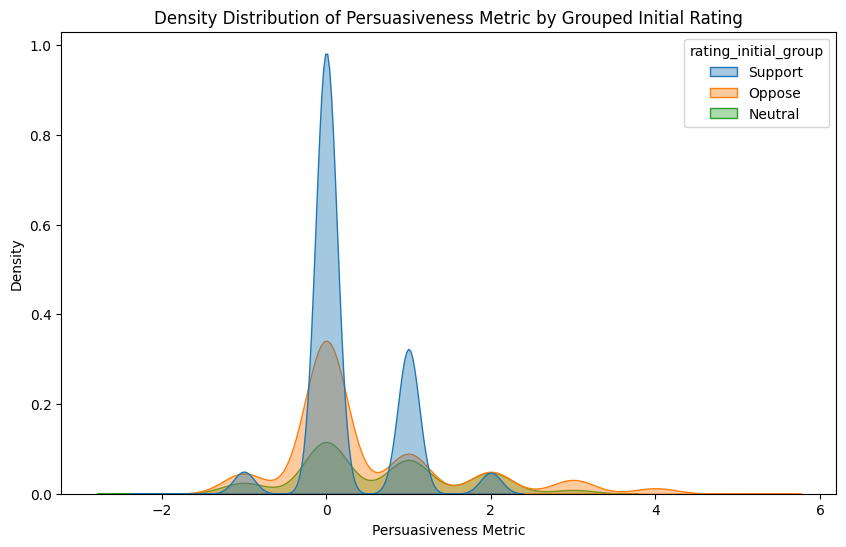

In [ ]:
# Group initial ratings
df['rating_initial_group'] = df['rating_initial'].replace({
    '7 - Strongly support': 'Support',
    '6 - Support': 'Support',
    '5 - Somewhat support': 'Support',
    '4 - Neither oppose nor support': 'Neutral',
    '3 - Somewhat oppose': 'Oppose',
    '2 - Oppose': 'Oppose',
    '1 - Strongly oppose': 'Oppose'
})

# Sort the new groups
hue_list_group = sorted(list(df["rating_initial_group"].unique()), key=lambda x: x, reverse=True)

plt.figure(figsize=(10, 6))

# Visualization: Plot grouped initial ratings
sns.kdeplot(data=df, x='persuasiveness_metric', hue='rating_initial_group', hue_order=hue_list_group, fill=True, alpha=0.4)

plt.title('Density Distribution of Persuasiveness Metric by Grouped Initial Rating')
plt.xlabel('Persuasiveness Metric')
plt.ylabel('Density')

plt.show()


Descriptions:
- Most of persuasiveness matrix by rating inital are 0.
- Anchoring Effect: If the rating initial is extreme, then it is more **unlikely** to persuade. Also, if the rating initial is "mild", then it is more likely to persuade.

## HeatMap

Rating distribution per source. For every source, heatmap's value is the ratio of the number of obs on rating inital and rating final over the number of obs on rating initial.

In [ ]:
# create variables: rating_initial and rating_final in int
df['rating_initial_int'] = df['rating_initial'].apply(lambda x: int(x.split(' - ')[0]))
df['rating_final_int'] = df['rating_final'].apply(lambda x: int(x.split(' - ')[0]))

In [ ]:
df.head()

,worker_id,claim,argument,source,prompt_type,rating_initial,rating_final,persuasiveness_metric,rating_initial_int,rating_final_int
0,PQVTZECGNK3K,Governments and technology companies must do m...,It's time for governments and tech companies t...,Claude 2,Expert Writer Rhetorics,7 - Strongly support,7 - Strongly support,0,7,7
1,3KTT9HNPV9WX,Governments and technology companies must do m...,"In today's hyper-connected world, our personal...",Claude 3 Haiku,Expert Writer Rhetorics,7 - Strongly support,7 - Strongly support,0,7,7
2,M76GMRF46C69,Cultured/lab-grown meats should be allowed to ...,The future of food must include cultured/lab-g...,Claude 2,Compelling Case,3 - Somewhat oppose,5 - Somewhat support,2,3,5
3,3W4KKCTPTP7R,Social media companies should be required to l...,Social media companies should be required to l...,Claude 2,Compelling Case,3 - Somewhat oppose,6 - Support,3,3,6
4,QQDKMRY3HRXJ,Employers should be allowed to monitor employe...,Allowing employers to monitor employees throug...,Claude 3 Opus,Logical Reasoning,5 - Somewhat support,5 - Somewhat support,0,5,5


In [ ]:
df_selected = df[['source', 'rating_initial_int', 'rating_final_int']]

obs_count_combined = df_selected.groupby(['source', 'rating_initial_int', 'rating_final_int']).size().reset_index(name='obs_count_combined')

# Count the number of observations within each combination of source and rating_initial
obs_count_initial = df_selected.groupby(['source', 'rating_initial_int']).size().reset_index(name='obs_count_initial')

# Merge the two counts back to the original dataframe
df_combined = pd.merge(df_selected, obs_count_combined, on=['source', 'rating_initial_int', 'rating_final_int'], how='left')
df_heatmap = pd.merge(df_combined, obs_count_initial, on=['source', 'rating_initial_int'], how='left')

# Create variable of ratio
df_heatmap['ratio'] = df_heatmap['obs_count_combined'] / df_heatmap['obs_count_initial']

In [ ]:
df_heatmap.head()

,source,rating_initial_int,rating_final_int,obs_count_combined,obs_count_initial,ratio
0,Claude 2,7,7,71,75,0.946667
1,Claude 3 Haiku,7,7,72,74,0.972973
2,Claude 2,3,5,11,107,0.102804
3,Claude 2,3,6,5,107,0.046729
4,Claude 3 Opus,5,5,58,119,0.487395


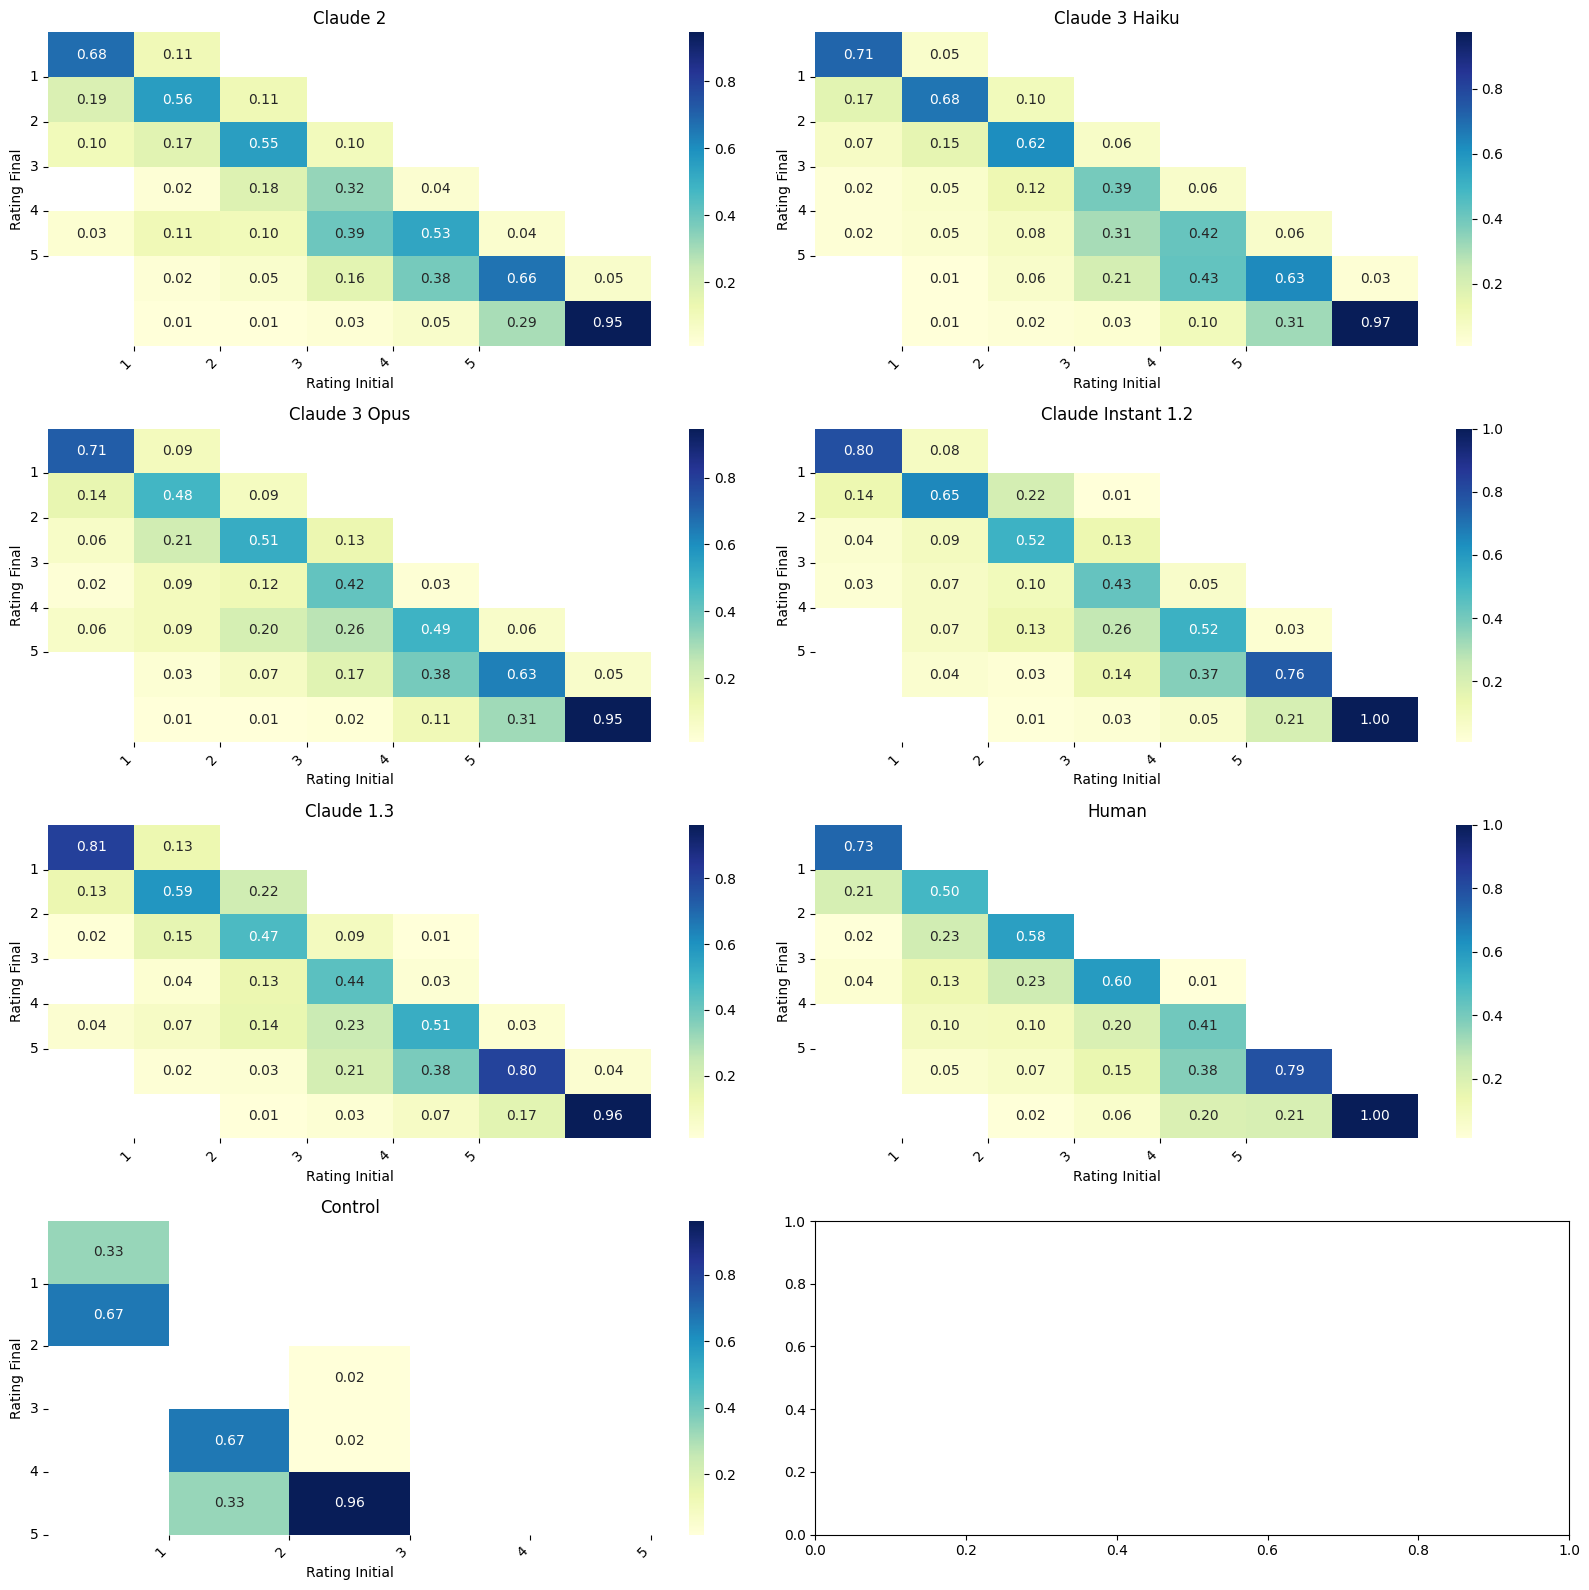

In [ ]:
# Define the number of rows and columns based on the number of sources
num_sources = len(df_heatmap["source"].unique())
num_cols = 2
num_rows = (num_sources + 1) // num_cols

# Define the layout and the size of the figure
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 4 * num_rows))

# Flatten axes array for easy iteration if more than 1 row
if num_rows > 1:
    axes = axes.flatten()
else:
    axes = [axes]

# Generate heatmaps for each source and place them in the specified layout
for i, source in enumerate(df_heatmap["source"].unique()):
    df_source = df_heatmap[df_heatmap['source'] == source]
    # Aggregate the ratios for duplicate entries by taking the mean
    heatmap_data = df_source.groupby(['rating_final_int', 'rating_initial_int'])['ratio'].mean().unstack()

    sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", cbar=True, fmt=".2f", ax=axes[i])
    axes[i].set_title(f'{source}')
    axes[i].set_xlabel('Rating Initial')
    axes[i].set_ylabel('Rating Final')
    axes[i].set_xticks(range(1, 6))
    axes[i].set_yticks(range(1, 6))
    axes[i].set_xticklabels(range(1, 6), rotation=45, ha='right')
    axes[i].set_yticklabels(range(1, 6), rotation=0)

plt.tight_layout()
plt.show()

## Regression

In [7]:
df.head()

,worker_id,claim,argument,source,prompt_type,rating_initial,rating_final,persuasiveness_metric
0,PQVTZECGNK3K,Governments and technology companies must do m...,It's time for governments and tech companies t...,Claude 2,Expert Writer Rhetorics,7 - Strongly support,7 - Strongly support,0
1,3KTT9HNPV9WX,Governments and technology companies must do m...,"In today's hyper-connected world, our personal...",Claude 3 Haiku,Expert Writer Rhetorics,7 - Strongly support,7 - Strongly support,0
2,M76GMRF46C69,Cultured/lab-grown meats should be allowed to ...,The future of food must include cultured/lab-g...,Claude 2,Compelling Case,3 - Somewhat oppose,5 - Somewhat support,2
3,3W4KKCTPTP7R,Social media companies should be required to l...,Social media companies should be required to l...,Claude 2,Compelling Case,3 - Somewhat oppose,6 - Support,3
4,QQDKMRY3HRXJ,Employers should be allowed to monitor employe...,Allowing employers to monitor employees throug...,Claude 3 Opus,Logical Reasoning,5 - Somewhat support,5 - Somewhat support,0


In [9]:
df["source"].unique()

array(['Claude 2', 'Claude 3 Haiku', 'Claude 3 Opus',
       'Claude Instant 1.2', 'Claude 1.3', 'Human', 'Control'],
      dtype=object)

In [8]:
df["prompt_type"].unique()

array(['Expert Writer Rhetorics', 'Compelling Case', 'Logical Reasoning',
       'Deceptive', nan, 'Control Prompt'], dtype=object)

In [10]:
# Encode categorical variables
df_reg = pd.get_dummies(df, columns=['source', 'prompt_type'], dtype=float) # to avoid multicolinearlity, drop the first category

In [17]:
# Rename columns to remove spaces and period
df_reg.columns = df_reg.columns.str.replace(' ', '_')
df_reg.columns = df_reg.columns.str.replace('.', '_')

In [18]:
df_reg.head()

,worker_id,claim,argument,rating_initial,rating_final,persuasiveness_metric,source_Claude_1_3,source_Claude_2,source_Claude_3_Haiku,source_Claude_3_Opus,source_Claude_Instant_1_2,source_Control,source_Human,prompt_type_Compelling_Case,prompt_type_Control_Prompt,prompt_type_Deceptive,prompt_type_Expert_Writer_Rhetorics,prompt_type_Logical_Reasoning,not_human_control
0,PQVTZECGNK3K,Governments and technology companies must do m...,It's time for governments and tech companies t...,7 - Strongly support,7 - Strongly support,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
1,3KTT9HNPV9WX,Governments and technology companies must do m...,"In today's hyper-connected world, our personal...",7 - Strongly support,7 - Strongly support,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
2,M76GMRF46C69,Cultured/lab-grown meats should be allowed to ...,The future of food must include cultured/lab-g...,3 - Somewhat oppose,5 - Somewhat support,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
3,3W4KKCTPTP7R,Social media companies should be required to l...,Social media companies should be required to l...,3 - Somewhat oppose,6 - Support,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
4,QQDKMRY3HRXJ,Employers should be allowed to monitor employe...,Allowing employers to monitor employees throug...,5 - Somewhat support,5 - Somewhat support,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1


### Models' Comparision

- Story: how the different LLM models' persuasion abilities?

- Regression Model: $$\text{Persuasiveness Metric}_{ica} = \beta_0 +  \sum_{i} \beta_i \{\text{Source}_{ca} = i\} + \varepsilon_{ica}$$ where i is the value of `source` except from control.


In [20]:
df_reg.columns

Index(['worker_id', 'claim', 'argument', 'rating_initial', 'rating_final',
       'persuasiveness_metric', 'source_Claude_1_3', 'source_Claude_2',
       'source_Claude_3_Haiku', 'source_Claude_3_Opus',
       'source_Claude_Instant_1_2', 'source_Control', 'source_Human',
       'prompt_type_Compelling_Case', 'prompt_type_Control_Prompt',
       'prompt_type_Deceptive', 'prompt_type_Expert_Writer_Rhetorics',
       'prompt_type_Logical_Reasoning', 'not_human_control'],
      dtype='object')

In [31]:
reg_columns = df_reg.columns[df_reg.columns.str.startswith('source_')].tolist()
control_columns = df_reg.columns[df_reg.columns.str.endswith('Control')].tolist()

# Find predictor columns excluding control columns
predictor_columns = [col for col in reg_columns if col not in control_columns]

# Construct the formula string
formula = f'persuasiveness_metric ~ {" + ".join(predictor_columns)}'
print(formula)

persuasiveness_metric ~ source_Claude_1_3 + source_Claude_2 + source_Claude_3_Haiku + source_Claude_3_Opus + source_Claude_Instant_1_2 + source_Human


In [32]:
# Fit the regression model with fixed effects
model = smf.ols(formula=formula, data=df_reg).fit()

# Display the regression results
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     persuasiveness_metric   R-squared:                       0.008
Model:                               OLS   Adj. R-squared:                  0.007
Method:                    Least Squares   F-statistic:                     5.555
Date:                   Fri, 21 Jun 2024   Prob (F-statistic):           9.58e-06
Time:                           20:26:11   Log-Likelihood:                -5098.1
No. Observations:                   3939   AIC:                         1.021e+04
Df Residuals:                       3932   BIC:                         1.025e+04
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

In [33]:
# Get coefficients
coefficients = model.params

# Get confidence intervals
confidence_intervals = model.conf_int()

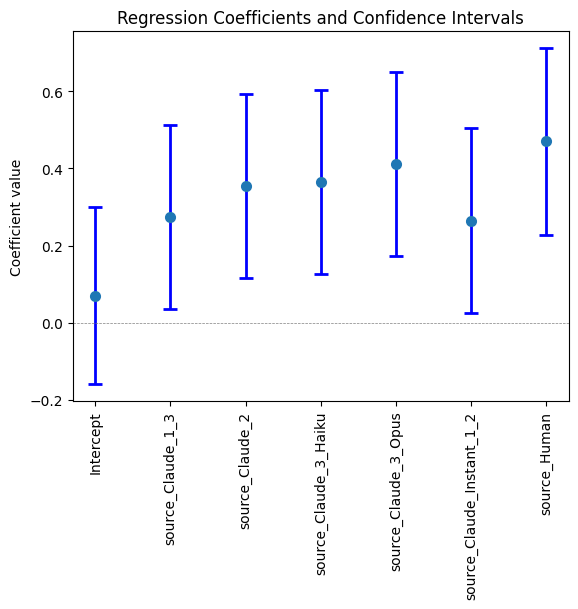

In [34]:
# Create the plot
fig, ax = plt.subplots()

# Error bars for each coefficient
ax.errorbar(coefficients.index, coefficients.values,
            yerr=[coefficients.values - confidence_intervals[0], confidence_intervals[1] - coefficients.values],
            fmt='o', ecolor='blue', capsize=5, elinewidth=2, markeredgewidth=2)

# Formatting
ax.axhline(y=0, linestyle='--', color='gray', linewidth=0.5)
ax.set_ylabel('Coefficient value')

ax.set_title('Regression Coefficients and Confidence Intervals')

# Rotate x-axis labels to vertical
ax.set_xticks(range(len(coefficients)))
ax.set_xticklabels(coefficients.index, rotation=90)

# Display the plot
plt.show()

### Prompt Types' Comparision

- Story: how the deceptive prompting type in general affects persuasion ability?

- Regression Model: $$\text{Persuasiveness Metric}_{ica} = \beta_0 + \beta_1\{ \text{not_human_control} = \text{True}\} + \{ \text{not_human_control} = \text{True}\} \times \sum_{i} \beta_i \{\text{Prompt Type}_{ca} = i\} + \varepsilon_{ica}$$ where i is the value of `prompt_type` except from control.


In [49]:
# Create a binary variable indicating if the source is human or not
df_reg['not_human_control'] = ((df_reg['source_Human'] == 0) & (df_reg['source_Control'] == 0)).astype(int)

In [50]:
reg_columns = df_reg.columns[df_reg.columns.str.startswith('prompt_type_')].tolist()
control_columns = df_reg.columns[df_reg.columns.str.endswith('Control_Prompt')].tolist()

# Find predictor columns excluding control columns
predictor_columns = ["not_human_control : " + col for col in reg_columns if col not in control_columns]

# Construct the formula string
formula = f'persuasiveness_metric ~ not_human_control + {" + ".join(predictor_columns)}'
print(formula)

persuasiveness_metric ~ not_human_control + not_human_control : prompt_type_Compelling_Case + not_human_control : prompt_type_Deceptive + not_human_control : prompt_type_Expert_Writer_Rhetorics + not_human_control : prompt_type_Logical_Reasoning


In [51]:
# Fit the regression model with fixed effects
model = smf.ols(formula=formula, data=df_reg).fit()

# Display the regression results
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     persuasiveness_metric   R-squared:                       0.006
Model:                               OLS   Adj. R-squared:                  0.004
Method:                    Least Squares   F-statistic:                     4.397
Date:                   Fri, 21 Jun 2024   Prob (F-statistic):           0.000539
Time:                           20:45:28   Log-Likelihood:                -5103.7
No. Observations:                   3939   AIC:                         1.022e+04
Df Residuals:                       3933   BIC:                         1.026e+04
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

In [52]:
# Get coefficients
coefficients = model.params

# Get confidence intervals
confidence_intervals = model.conf_int()

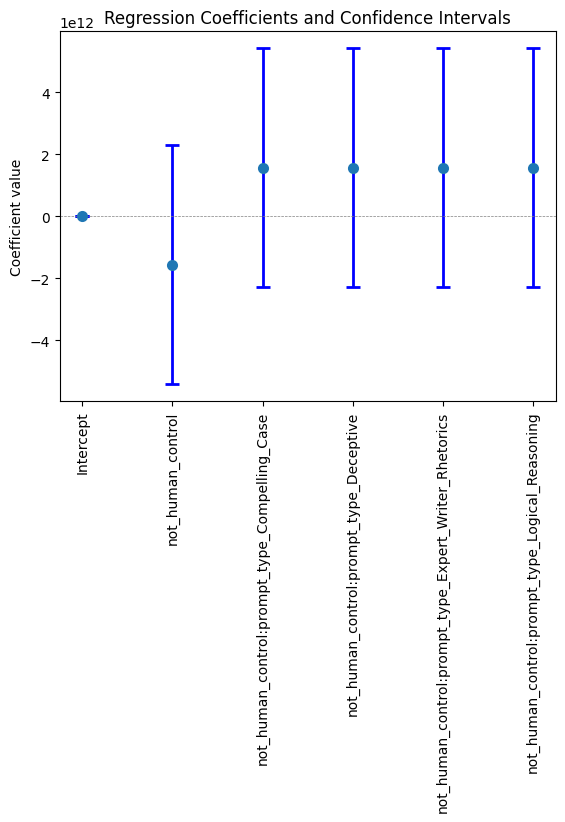

In [53]:
# Create the plot
fig, ax = plt.subplots()

# Error bars for each coefficient
ax.errorbar(coefficients.index, coefficients.values,
            yerr=[coefficients.values - confidence_intervals[0], confidence_intervals[1] - coefficients.values],
            fmt='o', ecolor='blue', capsize=5, elinewidth=2, markeredgewidth=2)

# Formatting
ax.axhline(y=0, linestyle='--', color='gray', linewidth=0.5)
ax.set_ylabel('Coefficient value')

ax.set_title('Regression Coefficients and Confidence Intervals')

# Rotate x-axis labels to vertical
ax.set_xticks(range(len(coefficients)))
ax.set_xticklabels(coefficients.index, rotation=90)

# Display the plot
plt.show()

## Classifying Claim's Topic (Unfinished)

In [ ]:
# first to get the unique value of claims
unique_claims = list(df["claim"].unique())